In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Manually Categorized Data

In [2]:
df = pd.read_csv('../data/react_samples_manual.csv')

In [3]:
fault_category = {
	"0": "Undefined/Null Variable Usage",
    "1": "Incorrect Method Parameter",
    "2": "Incorrect Method Usage",
    "3": "Incorrect Return Value",
    "4": "Incorrect Configuration",
    "5": "Performance",
    "6": "Other"
}

In [4]:
df['issue_number'] = df['html_url'].apply(lambda x: x.split('/')[-1].strip())
df['issue_number']

0     18686
1     16396
2     16583
3     26429
4     17520
      ...  
95    17592
96    19988
97    16457
98    20504
99    19383
Name: issue_number, Length: 100, dtype: object

In [5]:
df['Browser Specific'] = df['Browser Specific'].fillna(False)

In [6]:
df['Browser Specific'] = df['Browser Specific'].replace('Browser Specific', True)
df['Browser Specific'] = df['Browser Specific'].replace('Browser specific', True)
df['Browser Specific'].unique()

array([False,  True])

In [7]:
df_manual = df[['issue_number', 'Browser Specific', 'Fault Categories', 'cluster_label']].rename(columns={"Fault Categories": "fault_category", "Browser Specific": "browser_specific"})
df_manual

,issue_number,browser_specific,fault_category,cluster_label
0,18686,False,5,3
1,16396,False,6,3
2,16583,False,1,3
3,26429,False,4,3
4,17520,False,2,3
...,...,...,...,...
95,17592,False,1,0
96,19988,False,0,0
97,16457,False,1,0
98,20504,False,1,0


In [8]:
df_manual['fault_category'].unique()

array([5, 6, 1, 4, 2, 0, 3])

In [9]:
df_manual['fault_category_label'] = df_manual['fault_category'].apply(lambda x: fault_category[str(x)])
df_manual['fault_category_label']

0                       Performance
1                             Other
2        Incorrect Method Parameter
3           Incorrect Configuration
4            Incorrect Method Usage
                  ...              
95       Incorrect Method Parameter
96    Undefined/Null Variable Usage
97       Incorrect Method Parameter
98       Incorrect Method Parameter
99       Incorrect Method Parameter
Name: fault_category_label, Length: 100, dtype: object

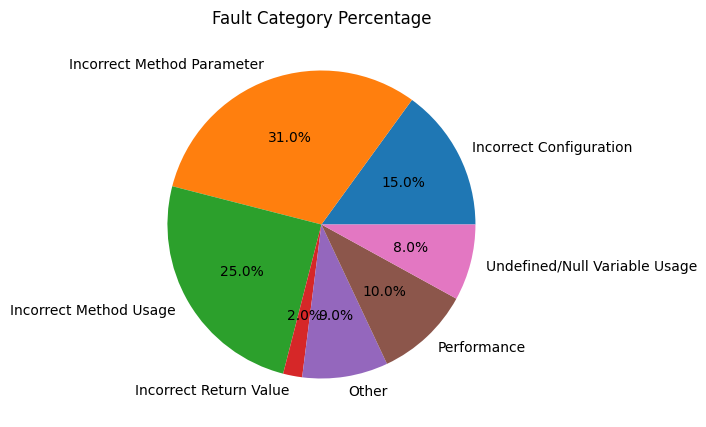

In [72]:
# pie chart
category_count_1 = df_manual.groupby("fault_category_label")["fault_category_label"].count().reset_index(name="count")
# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(category_count_1['count'], labels=category_count_1['fault_category_label'], autopct='%1.01f%%')
plt.title('Fault Category Percentage')
# Removing y-axis ticks
plt.yticks([])
plt.show()

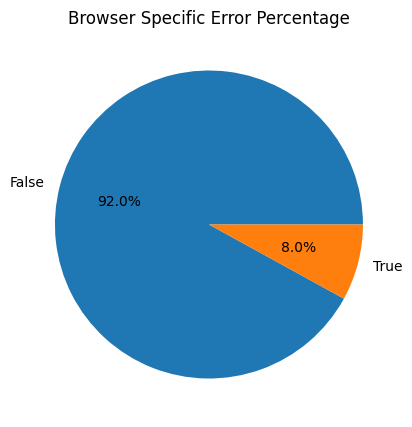

In [73]:
# pie chart
category_count_2 = df_manual.groupby("browser_specific")["browser_specific"].count().reset_index(name="count")
# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(category_count_2['count'], labels=category_count_2['browser_specific'], autopct='%1.01f%%')
plt.title('Browser Specific Error Percentage')
# Removing y-axis ticks
plt.yticks([])
plt.show()

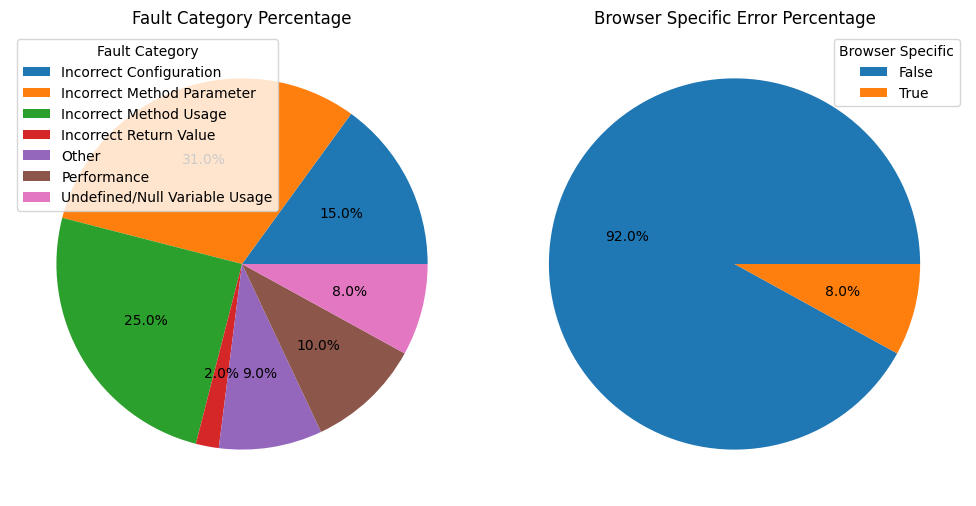

In [81]:
# Create subplots with two pie charts in a row
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first pie chart
axs[0].pie(category_count_1['count'], autopct='%1.01f%%')
axs[0].set_title('Fault Category Percentage')

# Plot the second pie chart
axs[1].pie(category_count_2['count'], autopct='%1.01f%%')
axs[1].set_title('Browser Specific Error Percentage')

axs[0].set_yticks([])
axs[1].set_yticks([])
axs[0].set_xticks([])
axs[1].set_xticks([])

# Add legend
axs[0].legend(category_count_1['fault_category_label'], title='Fault Category', loc='upper left')
axs[1].legend(category_count_2['browser_specific'], title='Browser Specific', loc='upper right')

plt.tight_layout()  
plt.show()

# Check the original data

## Cluster number = 5

In [12]:
df_orginal = pd.read_csv('../data/facebook_react_cluster_1.csv')

In [13]:
df_orginal['issue_number'] = df_orginal['html_url'].apply(lambda x: x.split('/')[-1].strip())
df_orginal = df_orginal[['issue_number', 'title', 'body', 'cluster_label']]

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if (token not in stopwords.words('english')) and (len(token) < 20)]
    str_tokens = ' '.join(tokens)
    return str_tokens

In [15]:
df_orginal['processed_title'] = df_orginal['title'].apply(preprocess_text)
df_orginal['processed_body'] = df_orginal['body'].apply(preprocess_text)
df_orginal['processed_text'] = df_orginal.apply(lambda row: f'Title: {row["processed_title"]}; Body: {row["processed_body"]}', axis=1)

In [16]:
df_merge = pd.merge(df_manual, df_orginal, on=['issue_number'], how='left')
df_merge = df_merge[['issue_number', 'processed_text', 'cluster_label_x', 'fault_category','fault_category_label', 'browser_specific']].rename(columns={'cluster_label_x': 'cluster_label'})
df_merge

,issue_number,processed_text,cluster_label,fault_category,fault_category_label,browser_specific
0,18686,Title: bug context value change results render...,3,5,Performance,False
1,16396,Title: usesubscription causes ui tearing rando...,3,6,Other,False
2,16583,Title: ie polyfill seems working reactscripts ...,3,1,Incorrect Method Parameter,False
3,26429,Title: unable run examples react tictactoe tut...,3,4,Incorrect Configuration,False
4,17520,Title: component test reports update wrapped a...,3,2,Incorrect Method Usage,False
...,...,...,...,...,...,...
95,17592,Title: error could find node id commit tree; B...,0,1,Incorrect Method Parameter,False
96,19988,Title: error read property iscollapsed undefin...,0,0,Undefined/Null Variable Usage,False
97,16457,Title: error could find node id commit tree; B...,0,1,Incorrect Method Parameter,False
98,20504,Title: error commit tree contain fiber bug rea...,0,1,Incorrect Method Parameter,False


## Cluster number = 7

In [17]:
df_orginal_2 = pd.read_csv('../data/facebook_react_cluster_2.csv')
df_orginal_2['issue_number'] = df_orginal_2['html_url'].apply(lambda x: x.split('/')[-1].strip())
df_orginal_2 = df_orginal_2[['issue_number', 'title', 'body', 'cluster_label']]
df_orginal_2['processed_title'] = df_orginal_2['title'].apply(preprocess_text)
df_orginal_2['processed_body'] = df_orginal_2['body'].apply(preprocess_text)
df_orginal_2['processed_text'] = df_orginal_2.apply(lambda row: f'Title: {row["processed_title"]}; Body: {row["processed_body"]}', axis=1)
df_merge_2 = pd.merge(df_manual, df_orginal_2, on=['issue_number'], how='left')
df_merge_2 = df_merge_2[['issue_number', 'processed_text', 'cluster_label_y', 'fault_category','fault_category_label', 'browser_specific']].rename(columns={'cluster_label_y': 'cluster_label'})
df_merge_2

,issue_number,processed_text,cluster_label,fault_category,fault_category_label,browser_specific
0,18686,Title: bug context value change results render...,5,5,Performance,False
1,16396,Title: usesubscription causes ui tearing rando...,2,6,Other,False
2,16583,Title: ie polyfill seems working reactscripts ...,6,1,Incorrect Method Parameter,False
3,26429,Title: unable run examples react tictactoe tut...,2,4,Incorrect Configuration,False
4,17520,Title: component test reports update wrapped a...,5,2,Incorrect Method Usage,False
...,...,...,...,...,...,...
95,17592,Title: error could find node id commit tree; B...,3,1,Incorrect Method Parameter,False
96,19988,Title: error read property iscollapsed undefin...,3,0,Undefined/Null Variable Usage,False
97,16457,Title: error could find node id commit tree; B...,3,1,Incorrect Method Parameter,False
98,20504,Title: error commit tree contain fiber bug rea...,3,1,Incorrect Method Parameter,False


## Cluster number = 7 & TFIDF

In [18]:
df_orginal_3 = pd.read_csv('../data/facebook_react_cluster_3.csv')
df_orginal_3['issue_number'] = df_orginal_3['html_url'].apply(lambda x: x.split('/')[-1].strip())
df_orginal_3 = df_orginal_3[['issue_number', 'title', 'body', 'cluster_label']]
df_orginal_3['processed_title'] = df_orginal_3['title'].apply(preprocess_text)
df_orginal_3['processed_body'] = df_orginal_3['body'].apply(preprocess_text)
df_orginal_3['processed_text'] = df_orginal_3.apply(lambda row: f'Title: {row["processed_title"]}; Body: {row["processed_body"]}', axis=1)
df_merge_3 = pd.merge(df_manual, df_orginal_3, on=['issue_number'], how='left')
df_merge_3 = df_merge_3[['issue_number', 'processed_text', 'cluster_label_y', 'fault_category','fault_category_label', 'browser_specific']].rename(columns={'cluster_label_y': 'cluster_label'})
df_merge_3

,issue_number,processed_text,cluster_label,fault_category,fault_category_label,browser_specific
0,18686,Title: bug context value change results render...,4,5,Performance,False
1,16396,Title: usesubscription causes ui tearing rando...,6,6,Other,False
2,16583,Title: ie polyfill seems working reactscripts ...,4,1,Incorrect Method Parameter,False
3,26429,Title: unable run examples react tictactoe tut...,4,4,Incorrect Configuration,False
4,17520,Title: component test reports update wrapped a...,6,2,Incorrect Method Usage,False
...,...,...,...,...,...,...
95,17592,Title: error could find node id commit tree; B...,1,1,Incorrect Method Parameter,False
96,19988,Title: error read property iscollapsed undefin...,2,0,Undefined/Null Variable Usage,False
97,16457,Title: error could find node id commit tree; B...,2,1,Incorrect Method Parameter,False
98,20504,Title: error commit tree contain fiber bug rea...,5,1,Incorrect Method Parameter,False


# Finding the count of each fault category in each cluster

## Cluster number = 5
Cluster 0 Keywords: [('commit reactdevtools error node', 0.5875), ('react devtools error getcommittree', 0.5828), ('commit tree react', 0.5823), ('jsx error commit tree', 0.5718), ('react devtools error commit', 0.567)]

Cluster 1 Keywords: [('component react memory leak', 0.6855), ('component bug react', 0.6453), ('memory leak react dom', 0.6432), ('react memory leak', 0.6423), ('react memory leak react', 0.6406)]

Cluster 2 Keywords: [('bug react error provide', 0.5963), ('bug react typescript support', 0.594), ('bug react dev', 0.591), ('error react support', 0.582), ('components error react', 0.581)]

Cluster 3 Keywords: [('bug setstate rerenders component', 0.5654), ('bug react longer supports', 0.5651), ('bugnext legacy reactdomrender', 0.5647), ('bug setstate rerender functional', 0.5614), ('single hook bug reactdomserver', 0.5599)]

Cluster 4 Keywords: [('bug build react', 0.5703), ('bug reactdom error devtools', 0.5565), ('electron app fails load', 0.556), ('errors react developer tools', 0.5518), ('electron app fails', 0.5442)]

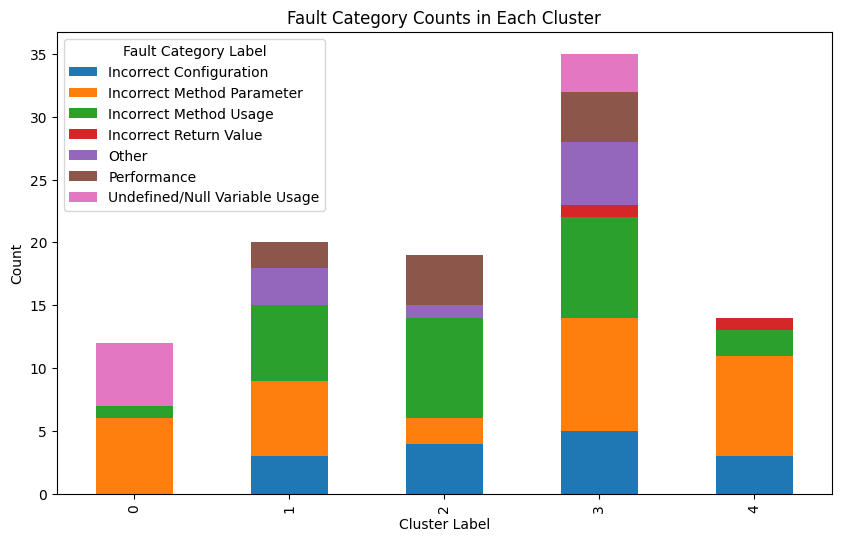

In [19]:
# Group by 'cluster_label' and 'fault_category_label', count occurrences
grouped_df = df_merge.groupby(['cluster_label', 'fault_category_label']).size().reset_index(name='count')

# Pivot the DataFrame to make 'fault_category_label' columns and 'count' values
pivot_df = grouped_df.pivot_table(index='cluster_label', columns='fault_category_label', values='count', fill_value=0)

# Plot the bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fault Category Counts in Each Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Fault Category Label')
plt.show()

## Cluster number = 7

Cluster 0 Keywords: [('using lazy components react', 0.7041), ('lazy components react', 0.7003), ('lazy components react router', 0.6884), ('react functional component', 0.5865), ('behavior react functional component', 0.584)]

Cluster 1 Keywords: [('devtools bug commit tree', 0.5058), ('parent node store devtools', 0.5033), ('node store devtools better', 0.5027), ('devtools bug add node', 0.5014), ('store devtools bug inspect', 0.4967)]

Cluster 2 Keywords: [('bug reactdomserver', 0.6669), ('bug reactdom', 0.6449), ('bug reactdomserver doesnt', 0.632), ('js bug reactdom', 0.6278), ('node js bug reactdom', 0.6274)]

Cluster 3 Keywords: [('id commit tree react', 0.5985), ('commit tree react', 0.595), ('commit tree error node', 0.561), ('commit tree contain fiber', 0.5523), ('node id commit tree', 0.5523)]

Cluster 4 Keywords: [('bug reactdom', 0.5609), ('reactdom breaks', 0.5551), ('reactdom bug missing', 0.5439), ('bug react dev', 0.5419), ('reactdom bug', 0.5403)]

Cluster 5 Keywords: [('bug reactdom', 0.6184), ('reactdomserver component errors bug', 0.6039), ('bug reactisvalidelement', 0.5995), ('unexpectedly bug reactisvalidelement', 0.5993), ('bug react', 0.5985)]

Cluster 6 Keywords: [('bug reactrefresh', 0.5385), ('bug react missing support', 0.5365), ('bug reactrefresh crashes', 0.5261), ('dependencies bug reactrefresh', 0.5133), ('dependencies bug reactrefresh crashes', 0.5128)]

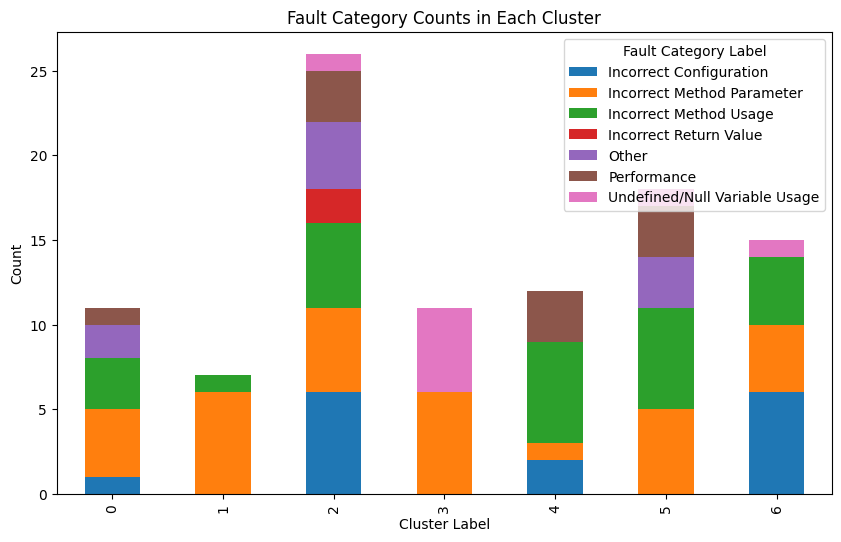

In [20]:
# Group by 'cluster_label' and 'fault_category_label', count occurrences
grouped_df = df_merge_2.groupby(['cluster_label', 'fault_category_label']).size().reset_index(name='count')

# Pivot the DataFrame to make 'fault_category_label' columns and 'count' values
pivot_df = grouped_df.pivot_table(index='cluster_label', columns='fault_category_label', values='count', fill_value=0)

# Plot the bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fault Category Counts in Each Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Fault Category Label')
plt.show()

## Cluster number = 7 & TFIDF

Cluster 0 Keywords: [('bug reactdom', 0.6551), ('bug reactdomserver', 0.6535), ('bug react version', 0.6401), ('bug react dev', 0.6352), ('bug react', 0.6302)]

Cluster 1 Keywords: [('node id commit tree', 0.6488), ('id commit tree', 0.6005), ('commit tree error node', 0.5883), ('commit tree', 0.5691), ('tree error commit data', 0.5611)]

Cluster 2 Keywords: [('react devtools error commit', 0.5028), ('reactdevtools error commit data', 0.4955), ('property undefined error commit', 0.4817), ('react devtools error getcommittree', 0.4807), ('react devtools error node', 0.4775)]

Cluster 3 Keywords: [('parent node store devtools', 0.5568), ('matching node store devtools', 0.5429), ('node id store devtools', 0.5362), ('node store devtools', 0.5352), ('devtools bug node id', 0.5298)]

Cluster 4 Keywords: [('jsx parser support', 0.6368), ('react new jsx', 0.5938), ('jsx parser', 0.5925), ('reactdomserver component errors api', 0.5879), ('reactdomserver component errors', 0.5796)]

Cluster 5 Keywords: [('commit tree contain fiber', 0.5727), ('commit tree contains fiber', 0.5589), ('react devtools error commit', 0.5566), ('error commit tree contain', 0.5541), ('devtools error commit tree', 0.5476)]

Cluster 6 Keywords: [('dom ssr crashes reactdom', 0.5648), ('component state devtools inspect', 0.5554), ('react dom ssr crashes', 0.5547), ('untested behavior new react', 0.5435), ('site undefined usestate inside', 0.5361)]

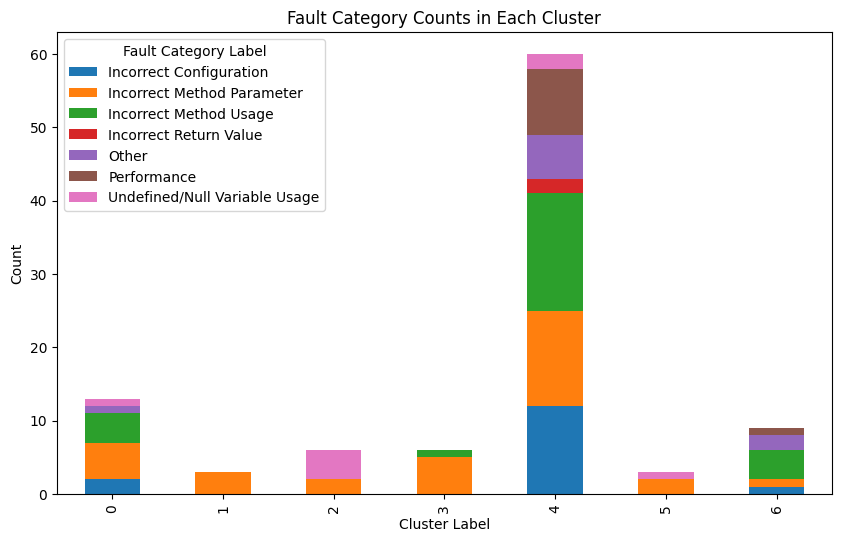

In [21]:
# Group by 'cluster_label' and 'fault_category_label', count occurrences
grouped_df = df_merge_3.groupby(['cluster_label', 'fault_category_label']).size().reset_index(name='count')

# Pivot the DataFrame to make 'fault_category_label' columns and 'count' values
pivot_df = grouped_df.pivot_table(index='cluster_label', columns='fault_category_label', values='count', fill_value=0)

# Plot the bar plot
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fault Category Counts in Each Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Fault Category Label')
plt.show()

# Find created time

In [22]:
df_raw = pd.read_json('../data/facebook_react.json')
df_raw.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'reactions', 'timeline_url',
       'performed_via_github_app', 'state_reason', 'score'],
      dtype='object')

In [23]:
df_raw['issue_number'] = df_raw['html_url'].apply(lambda x: x.split('/')[-1].strip())

In [24]:
df_created = df_raw[['issue_number', 'created_at']]

In [25]:
df_timed = pd.merge(df_merge, df_created, on=['issue_number'], how='left')
df_timed['created_year'] = df_timed['created_at'].apply(lambda x: str(x).split('-')[0])
df_timed

,issue_number,processed_text,cluster_label,fault_category,fault_category_label,browser_specific,created_at,created_year
0,18686,Title: bug context value change results render...,3,5,Performance,False,2020-04-21 04:21:07+00:00,2020
1,16396,Title: usesubscription causes ui tearing rando...,3,6,Other,False,2019-08-14 23:00:03+00:00,2019
2,16583,Title: ie polyfill seems working reactscripts ...,3,1,Incorrect Method Parameter,False,2019-08-27 11:36:47+00:00,2019
3,26429,Title: unable run examples react tictactoe tut...,3,4,Incorrect Configuration,False,2023-03-19 13:34:41+00:00,2023
4,17520,Title: component test reports update wrapped a...,3,2,Incorrect Method Usage,False,2019-12-04 07:28:25+00:00,2019
...,...,...,...,...,...,...,...,...
95,17592,Title: error could find node id commit tree; B...,0,1,Incorrect Method Parameter,False,2019-12-13 02:58:09+00:00,2019
96,19988,Title: error read property iscollapsed undefin...,0,0,Undefined/Null Variable Usage,False,2020-10-09 07:32:16+00:00,2020
97,16457,Title: error could find node id commit tree; B...,0,1,Incorrect Method Parameter,False,2019-08-19 17:12:37+00:00,2019
98,20504,Title: error commit tree contain fiber bug rea...,0,1,Incorrect Method Parameter,False,2020-12-23 10:31:08+00:00,2020


In [26]:
grouped_df = df_timed.groupby(['created_year', 'fault_category_label']).size().reset_index(name='count')
pivot_df = grouped_df.pivot_table(index='created_year', columns='fault_category_label', values='count', aggfunc='sum', fill_value=0)
pivot_df

fault_category_label,Incorrect Configuration,Incorrect Method Parameter,Incorrect Method Usage,Incorrect Return Value,Other,Performance,Undefined/Null Variable Usage
created_year,,,,,,,
2019,4,7,8,0,2,4,1
2020,4,11,5,1,5,4,3
2021,4,6,3,0,1,1,3
2022,1,5,7,0,1,1,0
2023,2,2,2,1,0,0,1


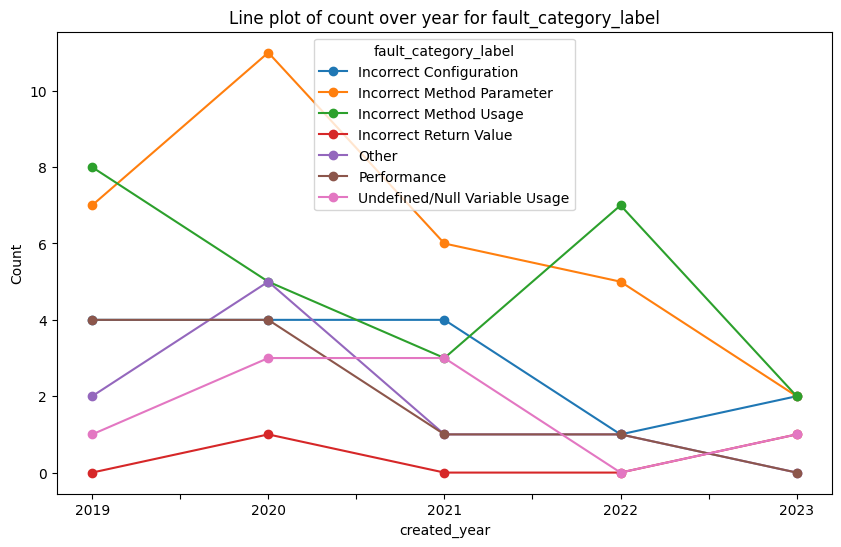

In [27]:
# Plot the line plot
pivot_df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Line plot of count over year for fault_category_label')
plt.xlabel('created_year')
plt.ylabel('Count')
plt.legend(title='fault_category_label')
plt.show()

# Classification

## BERT Model

In [60]:
# Load pre-trained BERT model and tokenizer
torch.cuda.empty_cache()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [61]:
# Freeze BERT parameters
for param in bert_model.parameters():
    param.requires_grad = False

In [62]:
# Add an MLP classification head on top of BERT
class CustomBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(CustomBERTClassifier, self).__init__()
        self.bert = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(bert_model.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        with torch.no_grad():
            outputs = self.bert(input_ids, attention_mask=attention_mask)
            
        # Extract pooled output (CLS token representation)
        cls_output = outputs.pooler_output
        
        logits = self.mlp(cls_output)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return loss
        else:
            return logits

In [63]:
# dataset
train, test = train_test_split(df_merge, test_size=0.2, random_state=42)

In [64]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device('cpu')

In [65]:
# dataloader
# Tokenize and create DataLoader
def create_dataloader(dataset, tokenizer, batch_size):
    encoded_data = tokenizer.batch_encode_plus(
        dataset['processed_text'].tolist(),
        return_tensors='pt', 
        truncation=True,
        padding=True
    )
    inputs = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)
    labels = torch.tensor(dataset['fault_category'].astype(int).tolist())  # Assuming you have labels for your dataset
    dataset = TensorDataset(inputs, attention_mask, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [66]:
batch_size = 4
train_dataloader = create_dataloader(train, tokenizer, batch_size=batch_size)
test_dataloader = create_dataloader(test, tokenizer, batch_size=batch_size)

In [67]:
# Instantiate the custom classifier
num_classes = 7
custom_classifier = CustomBERTClassifier(bert_model, num_classes)

In [68]:
# Define optimizer and training parameters
optimizer = torch.optim.AdamW(custom_classifier.parameters(), lr=2e-4)
num_epochs = 25

In [69]:
# Training loop
custom_classifier.to(device)
for epoch in range(num_epochs):
    custom_classifier.train()
    total_train_loss = 0.0
    
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer.zero_grad()
        loss = custom_classifier(input_ids, attention_mask=attention_mask, labels=labels)
        total_train_loss += loss.item()
    
        loss.backward()
        optimizer.step()
        
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Train Loss: {avg_train_loss}")

Epoch 1/25, Average Train Loss: 1.9507488787174225
Epoch 2/25, Average Train Loss: 2.044681024551392
Epoch 3/25, Average Train Loss: 1.865743213891983
Epoch 4/25, Average Train Loss: 1.8266886591911315
Epoch 5/25, Average Train Loss: 1.9406011164188386
Epoch 6/25, Average Train Loss: 1.8205164909362792
Epoch 7/25, Average Train Loss: 1.8591962337493897
Epoch 8/25, Average Train Loss: 1.8639538645744325
Epoch 9/25, Average Train Loss: 1.8563376069068909
Epoch 10/25, Average Train Loss: 1.8350713729858399
Epoch 11/25, Average Train Loss: 1.8288351356983186
Epoch 12/25, Average Train Loss: 1.7583842992782592
Epoch 13/25, Average Train Loss: 1.7429603338241577
Epoch 14/25, Average Train Loss: 1.8024862706661224
Epoch 15/25, Average Train Loss: 1.8004351496696471
Epoch 16/25, Average Train Loss: 1.7962420880794525
Epoch 17/25, Average Train Loss: 1.7301180899143218
Epoch 18/25, Average Train Loss: 1.7719386577606202
Epoch 19/25, Average Train Loss: 1.8409622311592102
Epoch 20/25, Average Tr

In [70]:
# Evaluation
custom_classifier.eval()
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        logits = custom_classifier(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()

        # Store true and predicted labels for later evaluation
        all_true_labels.extend(labels.cpu().numpy())
        all_pred_labels.extend(pred_labels)

# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_pred_labels)
print("Accuracy:", accuracy)


Accuracy: 0.3


## Other Classification Models

In [40]:
# Get data
data, labels = df_merge['processed_text'], df_merge['fault_category'].astype(int)

In [41]:
# Step 2: Text Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data)

In [42]:
# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_classifier = RandomForestClassifier(n_estimators=110, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.5


In [59]:
from sklearn.svm import SVC

# Create and train the model
svm_classifier = SVC(kernel='linear', C=1)
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Accuracy: 0.4


In [56]:
from sklearn.neighbors import KNeighborsClassifier

# Create and train the model
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

Accuracy: 0.4
